# Files upload

In [1]:
#Mount the drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Load the csv file
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

channels_units = []

file = open('/content/drive/MyDrive/03.012.csv')
file_data = csv.reader(file)
header = next(file_data)

#Re-arrange the data
for row in file_data:
  channels_units.append([row[0:2], row[2:]])

In [3]:
#Make a spike train of total ms length
#k = 1000 coefficient to make timescale in ms at 30000 sampling rate

def spike_trains_maker(times, k=1000):
  duration = 120.010033 #total duration of recording in seconds
  spike_timestamps, spike_indices = [], []
  spike_train = np.zeros(int(duration * k))
  
  spike_timestamps = times[1]
  spike_indices = [int(spike_timestamps[i]) // 30 for i in range(len(spike_timestamps))]
  
  spike_train[spike_indices] = 1

  return(spike_train)

# Autocorrelation & Crosscorrelation

In [ ]:
#Correlate pair of spike trains
channel_x = channels_units[20]
channel_y = channels_units[20]
x = spike_trains_maker(channel_x)
y = spike_trains_maker(channel_y)

corr_result = sp.signal.correlate(x, y, mode='full')

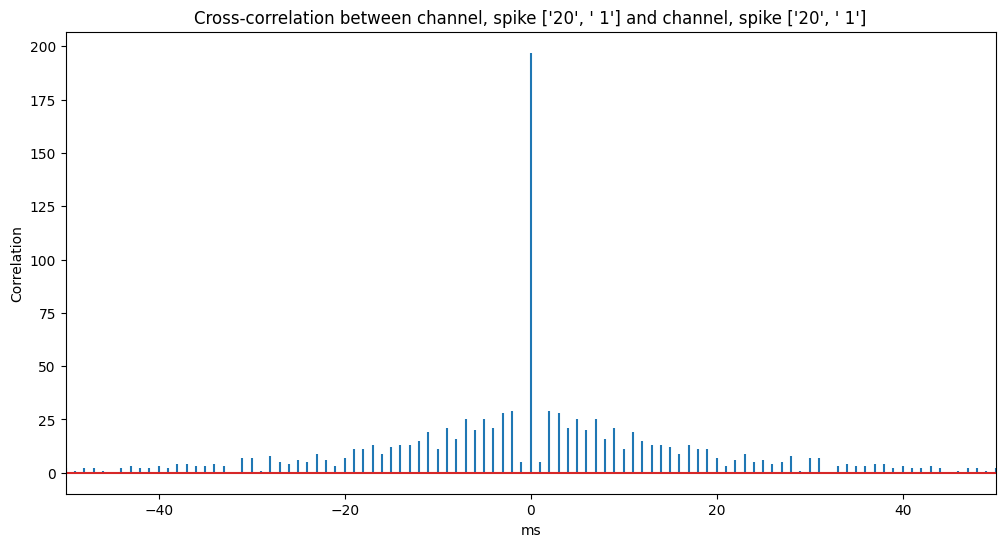

In [ ]:
#Plot the results
x_values = np.linspace(-len(corr_result)/2, len(corr_result)/2, len(corr_result))
x_values = np.round(x_values).astype(int)

plt.figure(figsize=(12, 6))
markerline, stemlines, baseline = plt.stem(
    x_values, corr_result, markerfmt='', bottom=0.0)
plt.xlabel('ms')
plt.xlim([-50, 50])
plt.ylabel('Correlation')
plt.title('Cross-correlation between channel, spike '+str(channel_x[0])+ ' and channel, spike '+str(channel_y[0]))
plt.show()

# Frequency analysis

https://stackoverflow.com/questions/13439718/how-to-interpret-the-values-returned-by-numpy-correlate-and-numpy-corrcoef

In [22]:
#Finding Interspike intervals (ISI)
channel_of_interest, Timestamps_of_interest, ISI = [],[],[]

channel_of_interest = channels_units[20]

Timestamps_of_interest = channel_of_interest[1]

for i in range(len(Timestamps_of_interest)):
    Timestamps_of_interest[i] = int(Timestamps_of_interest[i]) / 30

ISI = [Timestamps_of_interest[i+1] - Timestamps_of_interest[i] for i in range(len(Timestamps_of_interest)-1)]

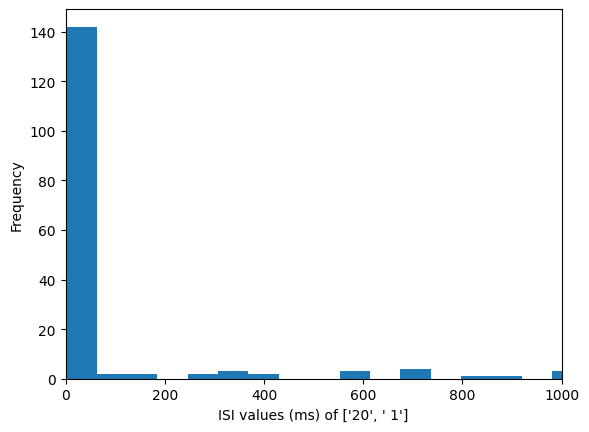

In [24]:
#Making a histogram of ISI distribution

#Calculate average of values between 0 and 1000 and make it a bin size
bin_size = np.mean([x for x in ISI if 0 <= x <= 1000])

plt.hist(ISI, bins=np.arange(min(ISI), max(ISI) + bin_size, bin_size))
plt.xlabel('ISI values (ms) of '+str(channel_of_interest[0]))
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()

# Correlogram (based on train A spikes)

In [ ]:
#Make spike trains for 2 channels of interest
channel_a = channels_units[1]
channel_b = channels_units[1]
a = spike_trains_maker(channel_a)
b = spike_trains_maker(channel_b)

spike_distribution_b = np.zeros(51)

for spike_time in np.nonzero(a)[0]:
    window_start = spike_time - 25
    window_end = spike_time + 26

    for k in range(window_start, window_end):
      if b[k] == 1:
        spike_distribution_b[k-window_start]+=1
      else:
        continue

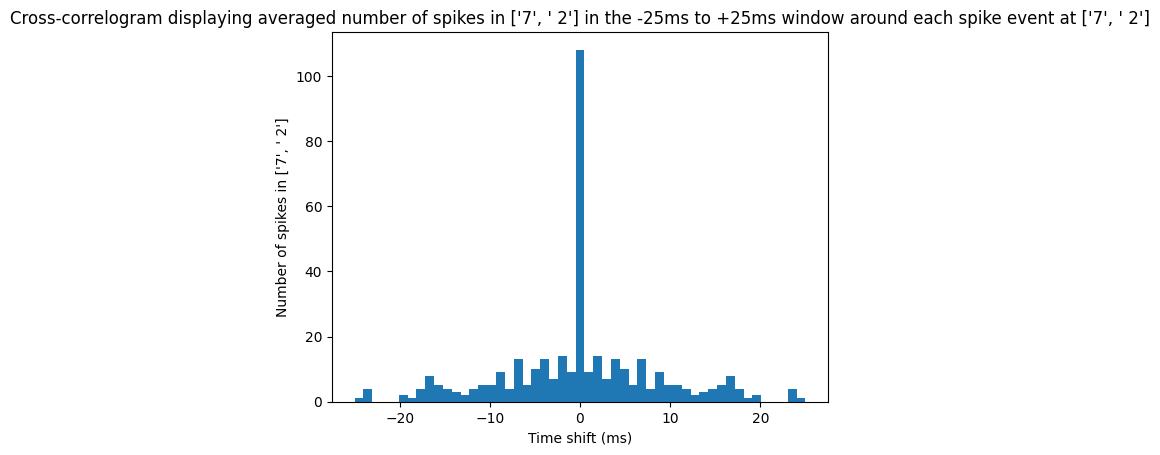

In [ ]:
#Make a histogram of average distribution of spikes in b around the spike event in a within -25,+25 ms range
x_values = range(-25, 26)
plt.hist(x_values, bins=len(x_values), weights=spike_distribution_b)
plt.xlabel('Time shift (ms)')
plt.ylabel('Number of spikes in '+str(channel_b[0]))
plt.title('Cross-correlogram displaying averaged number of spikes in '+str(channel_b[0])+ ' in the -25ms to +25ms window around each spike event at '+str(channel_a[0]))
plt.show()

# Artificial Signal Generation

In [ ]:
import random

#What channel will be used as spike source?
channel_a = channels_units[0]
a = spike_trains_maker(channel_a)

#Define the signal based on which you want to make artificial signals
art_chan = channels_units[1]
art = spike_trains_maker(art_chan)

In [ ]:
def art_trains_generator(art=art):
  #Find the positions of the 1s
  one_indices = [i for i, x in enumerate(art) if x == 1]
  
  #Calculate the intervals between the 1s
  intervals = [one_indices[i+1] - one_indices[i] - 1 for i in range(len(one_indices)-1)]
  intervals.append(len(art) - one_indices[-1] - 1)
  
  #Shuffle the intervals
  random.shuffle(intervals)
  
  #Build the shuffled list
  shuffled_art = []
  start_index = 0
  for interval in intervals:
    #Add the 1
    shuffled_art.append(1)
    #Add the 0s
    shuffled_art.extend([0] * interval)
    #Update the start index for the next segment
    start_index += interval + 1
    
  #Add the last segment of 0s (if any)
  if start_index < len(art):
    shuffled_art.extend([0] * (len(art) - start_index))

  return(shuffled_art)

In [ ]:
list_of_art_spike_distributions = []



for i in range(0,1000):
  
  b = art_trains_generator(art)
  spike_distribution_b = np.zeros(51)

  for spike_time in np.nonzero(a)[0]:
    window_start = spike_time - 25
    window_end = spike_time + 26
    
    for k in range(window_start, window_end):
      if b[k] == 1:
        spike_distribution_b[k-window_start]+=1
      else:
        continue

  list_of_art_spike_distributions.append(spike_distribution_b)

In [ ]:
#Calculate the mean list
mean_list_of_art_spike_distributions = np.mean(list_of_art_spike_distributions, axis=0)

#Calculate the standard error of the mean
sem = np.std(list_of_art_spike_distributions, axis=0) / np.sqrt(len(list_of_art_spike_distributions))

#Calculate the margin of error (95% confidence interval)
margin_of_error = 1.96 * sem

#Calculate the lower and upper boundaries of the confidence interval
lower_boundary_art = mean_list_of_art_spike_distributions - margin_of_error
upper_boundary_art = mean_list_of_art_spike_distributions + margin_of_error

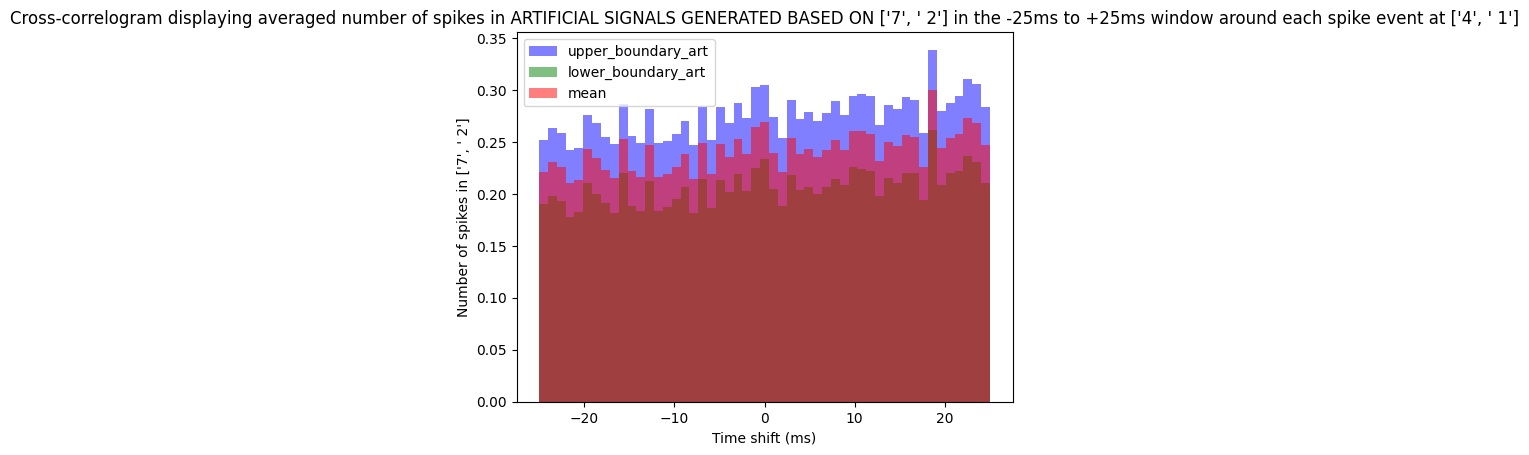

In [ ]:
#Make a histogram of average distribution of spikes in b around the spike event in a within -25,+25 ms range
x_values = range(-25, 26)
colors = ['blue', 'green', 'red']

plt.hist(x_values, bins=len(x_values), weights=upper_boundary_art, color=colors[0], alpha=0.5, label='upper_boundary_art')
plt.hist(x_values, bins=len(x_values), weights=lower_boundary_art, color=colors[1], alpha=0.5, label='lower_boundary_art')
plt.hist(x_values, bins=len(x_values), weights=mean_list_of_art_spike_distributions, color=colors[2], alpha=0.5, label='mean')

plt.xlabel('Time shift (ms)')
plt.ylabel('Number of spikes in '+str(art_chan[0]))
plt.title('Cross-correlogram displaying averaged number of spikes in ARTIFICIAL SIGNALS GENERATED BASED ON '+str(art_chan[0])+ ' in the -25ms to +25ms window around each spike event at '+str(channel_a[0]))
plt.legend()
plt.show()

# Upload LFP files

In [4]:
!pip install neo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#Open continuous recording file with Neo
from neo.io import BlackrockIO

filename = '/content/drive/MyDrive/230418_SpkCont_03.012.ns6'
reader = BlackrockIO(filename)
segments = reader.read_block().segments

# STA-LFP

In [6]:
#Extract the microvolt values
for segment in segments:
    for analog_signal in segment.analogsignals:
        microvolts = analog_signal.magnitude

In [7]:
#Extract microvolt values for specific channel necessary
necessary_channel = 3 #give the number by 1 less than number of channel
trace = []

for time in microvolts:
  trace.append(time[necessary_channel])

In [8]:
#Make spike train for the channel chosen previously
channel_n = channels_units[0]
n = spike_trains_maker(channel_n, k=30000)

microvolt_distribution_n = np.zeros(1530)

#Find an average microvolt distribution in the LFP of the same channel -25 ms to 25 ms around the spike event
for spike_time in np.nonzero(n)[0]:
    window_start = spike_time - 750
    window_end = spike_time + 780

    for k in range(window_start, window_end):
      microvolt_distribution_n[k-window_start]+=trace[k]

microvolt_distribution_n = [uV / len(np.nonzero(n)[0]) for uV in microvolt_distribution_n]

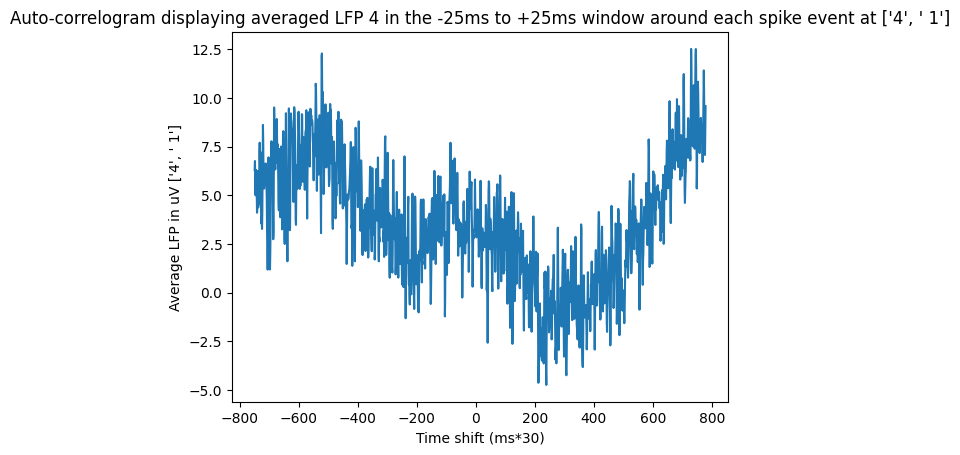

In [9]:
#Make a histogram of average distribution of LFP around the spike event in a within -25,+25 ms range
x_values = range(-750, 780)
plt.plot(x_values, microvolt_distribution_n)
plt.xlabel('Time shift (ms*30)')
plt.ylabel('Average LFP in uV '+str(channel_n[0]))
plt.title('Auto-correlogram displaying averaged LFP '+str(necessary_channel+1)+ ' in the -25ms to +25ms window around each spike event at '+str(channel_n[0]))
plt.show()

# Autocorrelation on LFP

In [15]:
x = trace

#resize the array to 120000 elements using numpy's resize() function
downsampled_x = np.resize(x, (120000,))

In [16]:
corr_result_LFP = sp.signal.correlate(downsampled_x, downsampled_x, mode='full')

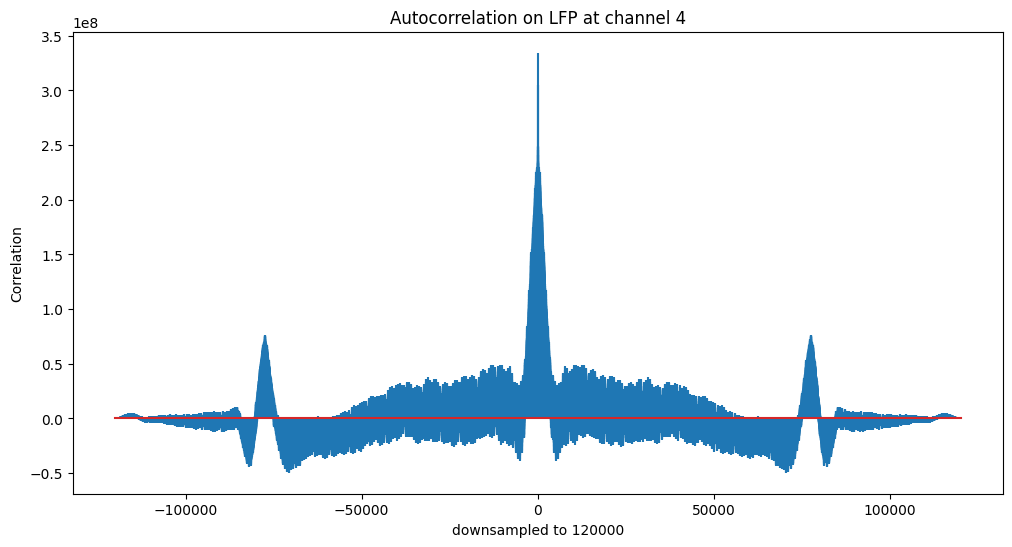

In [21]:
#Plot the results
x_values = np.linspace(-len(corr_result_LFP)/2, len(corr_result_LFP)/2, len(corr_result_LFP))
x_values = np.round(x_values).astype(int)

plt.figure(figsize=(12, 6))
markerline, stemlines, baseline = plt.stem(
    x_values, corr_result_LFP, markerfmt='', bottom=0.0)
plt.xlabel('downsampled to 120000')
#plt.xlim([-50, 50])
plt.ylabel('Correlation')
plt.title('Autocorrelation on LFP at channel '+str(necessary_channel+1))
plt.show()